In [1]:
import pandas as pd
import requests
import os

# NYC TLC publishes monthly parquet files
# Yellow taxi 2024 data

data_path = r"C:\IP\greenmlops\data\raw\nyc_taxi"
os.makedirs(data_path, exist_ok=True)

# Download a few months first (each file ~40-50 MB)
months = ['2024-01', '2024-02', '2024-03']  # Start with Q1

for month in months:
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet"
    filename = f"yellow_tripdata_{month}.parquet"
    filepath = os.path.join(data_path, filename)
    
    print(f"Downloading {month}...")
    response = requests.get(url, stream=True)
    
    if response.status_code == 200:
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"  ✅ Saved {filename}")
    else:
        print(f"  ❌ Failed: {response.status_code}")

print("\nDownload complete!")

  ✅ Saved yellow_tripdata_2024-01.parquet
  ✅ Saved yellow_tripdata_2024-02.parquet
  ✅ Saved yellow_tripdata_2024-03.parquet

Download complete!


In [2]:
import pandas as pd
import os

data_path = r"C:\IP\greenmlops\data\raw\nyc_taxi"

# Load Jan 2024
df = pd.read_parquet(os.path.join(data_path, "yellow_tripdata_2024-01.parquet"))

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic stats:")
print(df[['trip_distance', 'fare_amount', 'passenger_count']].describe())

Shape: (2964624, 19)

Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']

First few rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80

Original: 2,964,624 trips
After cleaning: 2,712,302 trips (91.5%)

Trip duration stats (minutes):
count    2.712302e+06
mean     1.492622e+01
std      1.169240e+01
min      1.016667e+00
25%      7.250000e+00
50%      1.165000e+01
75%      1.866667e+01
max      1.199667e+02
Name: trip_duration, dtype: float64

Plot saved!


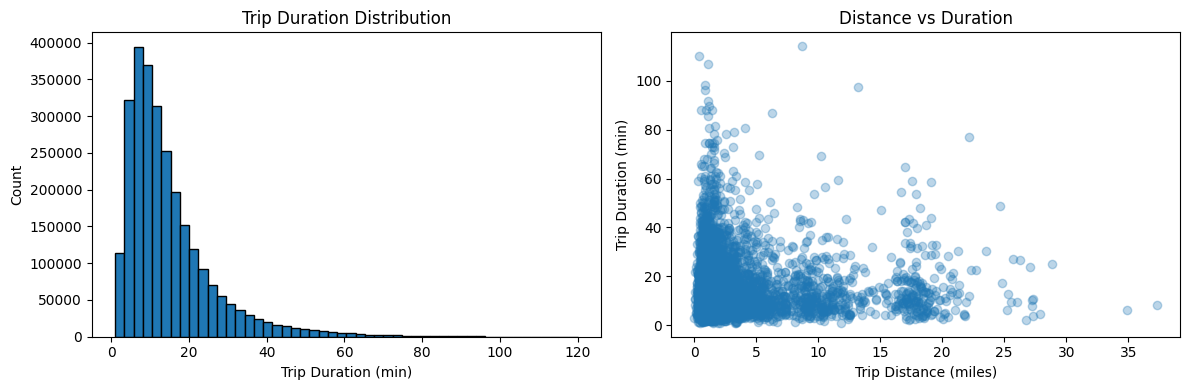

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_parquet(r"C:\IP\greenmlops\data\raw\nyc_taxi\yellow_tripdata_2024-01.parquet")

# Create target: trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Basic cleaning
df_clean = df[
    (df['trip_duration'] > 1) &  # At least 1 min
    (df['trip_duration'] < 120) &  # Max 2 hours
    (df['trip_distance'] > 0) &
    (df['trip_distance'] < 50) &  # Reasonable distance
    (df['fare_amount'] > 0) &
    (df['passenger_count'] > 0)
].copy()

print(f"Original: {len(df):,} trips")
print(f"After cleaning: {len(df_clean):,} trips ({len(df_clean)/len(df)*100:.1f}%)")
print(f"\nTrip duration stats (minutes):")
print(df_clean['trip_duration'].describe())

# Plot distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean['trip_duration'], bins=50, edgecolor='black')
plt.xlabel('Trip Duration (min)')
plt.ylabel('Count')
plt.title('Trip Duration Distribution')

plt.subplot(1, 2, 2)
plt.scatter(df_clean['trip_distance'].sample(5000), 
            df_clean['trip_duration'].sample(5000), alpha=0.3)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Duration (min)')
plt.title('Distance vs Duration')

plt.tight_layout()
plt.savefig(r"C:\IP\greenmlops\data\raw\nyc_taxi\trip_duration_eda.png", dpi=150)
print("\nPlot saved!")

In [4]:
import pandas as pd

data_path = r"C:\IP\greenmlops\data\raw\nyc_taxi"

# Load all 3 months
months_data = []
for month in ['2024-01', '2024-02', '2024-03']:
    df = pd.read_parquet(f"{data_path}/yellow_tripdata_{month}.parquet")
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df['month'] = month
    months_data.append(df)

df_all = pd.concat(months_data, ignore_index=True)

# Clean
df_clean = df_all[
    (df_all['trip_duration'] > 1) &
    (df_all['trip_duration'] < 120) &
    (df_all['trip_distance'] > 0) &
    (df_all['trip_distance'] < 50) &
    (df_all['fare_amount'] > 0)
].copy()

print(f"Total trips: {len(df_clean):,}")
print("\nTrips per month:")
print(df_clean['month'].value_counts().sort_index())

# Extract features
df_clean['hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['day_of_week'] = df_clean['tpep_pickup_datetime'].dt.dayofweek
df_clean['day_of_month'] = df_clean['tpep_pickup_datetime'].dt.day

# Save combined dataset
df_clean.to_parquet(f"{data_path}/nyc_taxi_Q1_2024_clean.parquet", index=False)
print(f"\nSaved: nyc_taxi_Q1_2024_clean.parquet")
print(f"Final shape: {df_clean.shape}")

Total trips: 9,173,394

Trips per month:
month
2024-01    2857758
2024-02    2889963
2024-03    3425673
Name: count, dtype: int64

Saved: nyc_taxi_Q1_2024_clean.parquet
Final shape: (9173394, 24)


In [5]:
import pandas as pd

data_path = r"C:\IP\greenmlops\data\raw\nyc_taxi"
df = pd.read_parquet(f"{data_path}/nyc_taxi_Q1_2024_clean.parquet")

# Sample 100k trips (keeps file manageable, still enough for ML)
df_sample = df.sample(n=100000, random_state=42).sort_values('tpep_pickup_datetime').reset_index(drop=True)

print(f"Sampled: {len(df_sample):,} trips")
print(f"Date range: {df_sample['tpep_pickup_datetime'].min()} to {df_sample['tpep_pickup_datetime'].max()}")

# Keep only features needed for ML
features = [
    'tpep_pickup_datetime',
    'trip_distance', 
    'passenger_count',
    'PULocationID',
    'DOLocationID', 
    'hour',
    'day_of_week',
    'trip_duration'  # Target
]

df_final = df_sample[features].copy()

print(f"\nFinal shape: {df_final.shape}")
print(f"\nMissing values:\n{df_final.isnull().sum()}")

df_final.to_csv(f"{data_path}/nyc_taxi_100k_2024.csv", index=False)
print("\nSaved: nyc_taxi_100k_2024.csv")

Sampled: 100,000 trips
Date range: 2024-01-01 00:01:25 to 2024-03-31 23:57:35

Final shape: (100000, 8)

Missing values:
tpep_pickup_datetime       0
trip_distance              0
passenger_count         6809
PULocationID               0
DOLocationID               0
hour                       0
day_of_week                0
trip_duration              0
dtype: int64

Saved: nyc_taxi_100k_2024.csv
